In [47]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
import time


In [48]:
df = pd.read_csv('TRAFFIC_DATA.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'], dayfirst=True)
df.set_index('timestamp', inplace=True)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52704 entries, 2024-01-01 00:00:00 to 2024-12-31 23:00:00
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   zone                     52704 non-null  object 
 1   vehicle_count            52704 non-null  float64
 2   avg_speed                52704 non-null  float64
 3   traffic_density          52704 non-null  int64  
 4   event                    52704 non-null  object 
 5   crowd_size               52704 non-null  int64  
 6   event_zone               52704 non-null  object 
 7   event_duration           52704 non-null  int64  
 8   weather_condition        52704 non-null  object 
 9   temperature              52704 non-null  float64
 10  visibility               52704 non-null  float64
 11  road_condition           52704 non-null  object 
 12  maintenance_work         52704 non-null  bool   
 13  public_transport_status  52704 non-null  

,zone,vehicle_count,avg_speed,traffic_density,event,crowd_size,event_zone,event_duration,weather_condition,temperature,visibility,road_condition,maintenance_work,public_transport_status,surge_pricing,latitude,longitude,altitude,road_width
timestamp,,,,,,,,,,,,,,,,,,,
2024-01-01,zone1,280.000000,41.618878,298,sports match,22050,zone5,1,storm,34.411409,46.692807,normal,False,delayed,0.305911,40.709558,-74.012229,335.106448,11.316029
2024-01-01,zone2,32.783791,49.599189,366,concert,20018,zone2,2,clear,32.809166,74.551171,accident,True,delayed,1.959962,34.061572,-118.251504,321.487073,12.061609
2024-01-01,zone3,142.553539,84.718597,286,conference,21548,zone1,3,rain,26.870429,3.106786,normal,True,on-time,0.125522,41.882067,-87.636344,337.336458,4.999346
2024-01-01,zone4,110.861088,106.268678,225,concert,13610,zone4,3,clear,13.982181,53.541058,normal,False,delayed,1.534334,29.763372,-95.379769,323.175344,20.000590
2024-01-01,zone5,107.397384,46.760665,141,movie release,45685,zone6,3,snow,12.217524,86.009432,road blockage,False,on-time,0.213348,33.442173,-112.073535,319.783101,5.000810


In [49]:
df.ffill(inplace=True)

In [50]:
features = ['vehicle_count', 'avg_speed', 'traffic_density', 'event', 'crowd_size',
            'weather_condition', 'temperature', 'road_condition', 'zone',
            'latitude', 'longitude', 'altitude', 'road_width']

In [51]:
categorical_features = ['event', 'weather_condition', 'road_condition']
numerical_features = ['vehicle_count', 'avg_speed', 'traffic_density', 'crowd_size',
                      'temperature', 'latitude', 'longitude', 'altitude', 'road_width']

In [52]:
#Encode categorical features
encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded_cats = encoder.fit_transform(df[categorical_features])

#Scale numerical features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_numerical = scaler.fit_transform(df[numerical_features])

#Combine scaled numerical and encoded categorical features
data = np.concatenate([scaled_numerical, encoded_cats], axis=1)


In [53]:
def get_max_vehicle_capacity(road_width):
    # Assume each meter of road width can accommodate up to 2 vehicles
    return road_width * 2

In [54]:
#Create sequences of data including road width for calculating capacity
def create_sequences_with_capacity(data, seq_length, road_widths):
    sequences = []
    labels = []
    capacities = []
    for i in range(seq_length, len(data)):
        sequences.append(data[i-seq_length:i])
        labels.append(data[i][0])  # vehicle count as the label
        capacities.append(get_max_vehicle_capacity(road_widths[i]))  # Calculate capacity
    return np.array(sequences), np.array(labels), np.array(capacities)


In [55]:
#Extract road widths and create input sequences
road_widths = df['road_width'].values
SEQ_LENGTH = 60
X, y, max_capacities = create_sequences_with_capacity(data, SEQ_LENGTH, road_widths)


In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [57]:
#Define LSTM model for traffic prediction
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')



In [58]:
#Train the LSTM model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/10


2024-10-19 15:46:14.516615: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 222367200 exceeds 10% of free system memory.


1315/1317 [============================>.] - ETA: 0s - loss: 0.0464

2024-10-19 15:46:50.059212: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 55593120 exceeds 10% of free system memory.


1317/1317 [==============================] - 39s 27ms/step - loss: 0.0464 - val_loss: 0.0355
Epoch 2/10
1317/1317 [==============================] - 35s 27ms/step - loss: 0.0362 - val_loss: 0.0351
Epoch 3/10
1317/1317 [==============================] - 36s 27ms/step - loss: 0.0352 - val_loss: 0.0345
Epoch 4/10
1317/1317 [==============================] - 45s 34ms/step - loss: 0.0348 - val_loss: 0.0347
Epoch 5/10
1317/1317 [==============================] - 109s 83ms/step - loss: 0.0348 - val_loss: 0.0342
Epoch 6/10
1317/1317 [==============================] - 79s 60ms/step - loss: 0.0346 - val_loss: 0.0343
Epoch 7/10
1317/1317 [==============================] - 119s 90ms/step - loss: 0.0345 - val_loss: 0.0342
Epoch 8/10
1317/1317 [==============================] - 117s 89ms/step - loss: 0.0345 - val_loss: 0.0343
Epoch 9/10
1317/1317 [==============================] - 56s 42ms/step - loss: 0.0345 - val_loss: 0.0342
Epoch 10/10
1317/1317 [==============================] - 50s 38ms/step -

In [18]:
predictions = model.predict(X_test)

2024-10-19 13:56:55.443236: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 55593120 exceeds 10% of free system memory.


330/330 [==============================] - 5s 13ms/step


In [19]:
#Rescale predictions to original scale
predicted_congestion_rescaled = scaler.inverse_transform(
    np.concatenate((predictions, X_test[:, -1, 1:len(numerical_features)]), axis=1)
)[:, 0]

In [20]:
#Adjust vehicle counts based on road capacity
predicted_congestion_adjusted = np.minimum(predicted_congestion_rescaled, max_capacities[:len(predicted_congestion_rescaled)])

In [21]:
#Define zones from the original dataset
zones = df['zone'].unique()

In [22]:
#Perform rerouting if predicted congestion exceeds capacity
rerouted_zones = [zones[(int(cong) + 1) % len(zones)] if cong > max_capacities[i]
                  else zones[int(cong) % len(zones)]
                  for i, cong in enumerate(predicted_congestion_adjusted)]

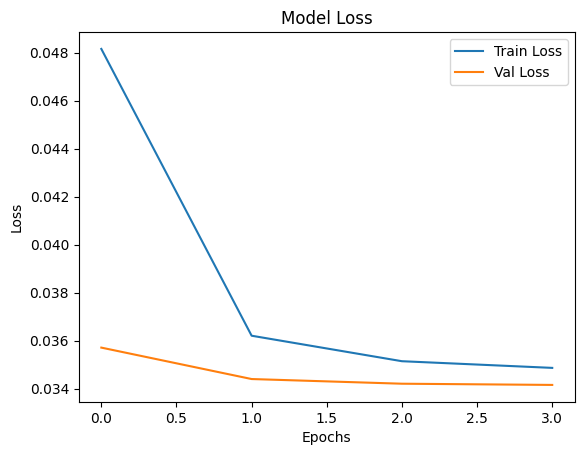

In [23]:
#Plot training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [24]:
#Output predicted congestion and rerouting suggestions
# Convert index (timestamp) to list to access it easily
timestamps = df.index.tolist()
current_timestamp = None
# Displays Congestion & Rerouting details for the first 24 hours
for i in range(24*6):
    if timestamps[i] != current_timestamp:
        current_timestamp = timestamps[i]
        print(f"\nTimestamp: {current_timestamp.strftime('%Y/%m/%d %H:%M')}")

    print(f"Predicted Congestion: {predicted_congestion_adjusted[i]:<15.2f}, "
          f"Current Zone: {df['zone'][i]:<10}, "
          f"Suggested Rerouting Zone: {rerouted_zones[i]:<15}")


Timestamp: 2024/01/01 00:00
Predicted Congestion: 22.63          , Current Zone: zone1     , Suggested Rerouting Zone: zone5          
Predicted Congestion: 24.12          , Current Zone: zone2     , Suggested Rerouting Zone: zone1          
Predicted Congestion: 10.00          , Current Zone: zone3     , Suggested Rerouting Zone: zone5          
Predicted Congestion: 40.00          , Current Zone: zone4     , Suggested Rerouting Zone: zone4          
Predicted Congestion: 10.00          , Current Zone: zone5     , Suggested Rerouting Zone: zone5          
Predicted Congestion: 30.00          , Current Zone: zone6     , Suggested Rerouting Zone: zone1          

Timestamp: 2024/01/01 01:00
Predicted Congestion: 22.63          , Current Zone: zone1     , Suggested Rerouting Zone: zone5          
Predicted Congestion: 24.12          , Current Zone: zone2     , Suggested Rerouting Zone: zone1          
Predicted Congestion: 10.00          , Current Zone: zone3     , Suggested Rerouting Z

/tmp/ipykernel_45/2625904430.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f"Current Zone: {df['zone'][i]:<10}, "


In [25]:
#Create a DataFrame with necessary features for the prediction report
predictions_df = pd.DataFrame({
    'timestamp': df.index[:len(predicted_congestion_adjusted)],
    'congestion_level': predicted_congestion_adjusted / max_capacities[:len(predicted_congestion_adjusted)],  # Normalized congestion level
    'zone': df['zone'][:len(predicted_congestion_adjusted)],
    'rerouted_zone': rerouted_zones[:len(predicted_congestion_adjusted)],
    'max_capacity': max_capacities[:len(predicted_congestion_adjusted)],
    'vehicle_count_before': df['vehicle_count'][:len(predicted_congestion_adjusted)],
    'vehicle_count_after': np.minimum(predicted_congestion_adjusted, max_capacities[:len(predicted_congestion_adjusted)]),
})


In [27]:
#Save to a CSV file
predictions_csv_path = 'prediction.csv'  # Specify your desired path
predictions_df.to_csv(predictions_csv_path, index=False)

print(f"Predictions saved to {predictions_csv_path}")

Predictions saved to prediction.csv


In [28]:
#Add rerouted zones to the DataFrame
df['rerouted_zones'] = np.nan  # Initialize with NaN
df.iloc[-len(rerouted_zones):, df.columns.get_loc('rerouted_zones')] = rerouted_zones

/tmp/ipykernel_45/2251586173.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['zone5', 'zone1', 'zone5', 'zone4', 'zone5', 'zone1', 'zone5', 'zone1', 'zone5', 'zone4', 'zone4', 'zone1', 'zone5', 'zone1', 'zone5', 'zone5', 'zone5', 'zone1', 'zone5', 'zone1', 'zone4', 'zone5', 'zone5', 'zone6', 'zone5', 'zone1', 'zone4', 'zone4', 'zone5', 'zone6', 'zone5', 'zone1', 'zone4', 'zone5', 'zone5', 'zone1', 'zone5', 'zone1', 'zone4', 'zone5', 'zone5', 'zone1', 'zone5', 'zone1', 'zone5', 'zone4', 'zone4', 'zone1', 'zone5', 'zone1', 'zone4', 'zone4', 'zone4', 'zone6', 'zone5', 'zone1', 'zone5', 'zone5', 'zone4', 'zone1', 'zone5', 'zone1', 'zone5', 'zone4', 'zone4', 'zone6', 'zone5', 'zone1', 'zone4', 'zone4', 'zone4', 'zone1', 'zone5', 'zone1', 'zone4', 'zone5', 'zone5', 'zone1', 'zone5', 'zone1', 'zone5', 'zone5', 'zone4', 'zone1', 'zone5', 'zone1', 'zone4', 'zone5', 'zone5', 'zone1', 'zone5', 'zone1', 'zone5', 'zone5', 

In [29]:
# Group by zones and calculate average vehicle count and other features before and after rerouting
before_rerouting_data = df.groupby('zone')[['vehicle_count', 'latitude', 'longitude', 'altitude']].mean().reset_index()
after_rerouting_data = df.groupby('rerouted_zones')[['vehicle_count', 'latitude', 'longitude', 'altitude']].mean().reset_index()


In [30]:
#Debugging - print grouped data
print(before_rerouting_data.head())
print(after_rerouting_data.head())


    zone  vehicle_count   latitude   longitude    altitude
0  zone1     157.479053  40.712789  -74.005948  335.386056
1  zone2      60.302110  34.052117 -118.243644  323.250207
2  zone3     123.030110  41.878087  -87.629865  333.806067
3  zone4      84.521434  29.760447  -95.369879  323.918714
4  zone5     111.128089  33.448388 -112.074044  323.815463
  rerouted_zones  vehicle_count   latitude   longitude    altitude
0          zone1     135.813096  41.434934  -83.234510  334.295525
1          zone2     108.704017  33.449210 -112.075417  323.892849
2          zone3     118.478892  33.448692 -112.075662  324.048238
3          zone4      80.184247  34.237601 -104.004302  325.655104
4          zone5      71.073976  34.277960 -109.913136  324.729429


In [31]:
#Perform K-Means clustering before rerouting
kmeans_before = KMeans(n_clusters=3, random_state=42)
before_rerouting_data['cluster'] = kmeans_before.fit_predict(before_rerouting_data[['vehicle_count', 'latitude', 'longitude', 'altitude']])


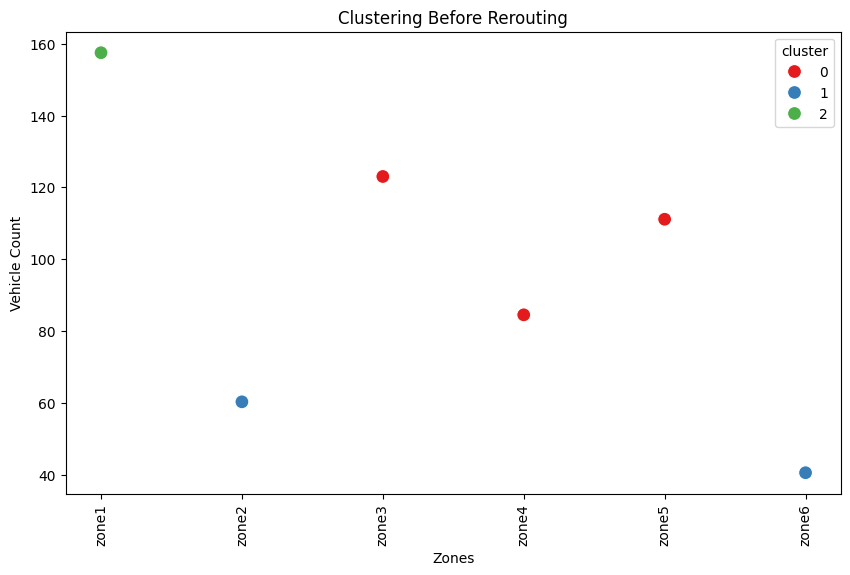

In [32]:
#Plot clustering results before rerouting
plt.figure(figsize=(10, 6))
sns.scatterplot(x=before_rerouting_data['zone'],
                y=before_rerouting_data['vehicle_count'],
                hue=before_rerouting_data['cluster'],
                palette='Set1', s=100)
plt.xlabel("Zones")
plt.ylabel("Vehicle Count")
plt.title("Clustering Before Rerouting")
plt.xticks(rotation=90)
plt.show()

In [34]:
#Handle mismatched length of rerouted zones and original DataFrame
if len(rerouted_zones) < len(df):
    rerouted_zones = np.resize(rerouted_zones, len(df))
elif len(rerouted_zones) > len(df):
    rerouted_zones = rerouted_zones[:len(df)]

# Assign rerouted zones back to DataFrame
df['rerouted_zone'] = rerouted_zones

In [35]:
#Group data by rerouted zones and perform clustering
after_rerouting_data = df.groupby('rerouted_zone')['vehicle_count'].mean().reset_index()

# Ensure enough samples for clustering
if len(after_rerouting_data) >= 3:
    kmeans_after = KMeans(n_clusters=3, random_state=42)
    after_rerouting_data['cluster'] = kmeans_after.fit_predict(after_rerouting_data[['vehicle_count']])
else:
    print(f"Not enough samples for KMeans clustering. Available samples: {len(after_rerouting_data)}")
    after_rerouting_data['cluster'] = np.zeros(len(after_rerouting_data))  # Assign all to one cluster if not enough samples


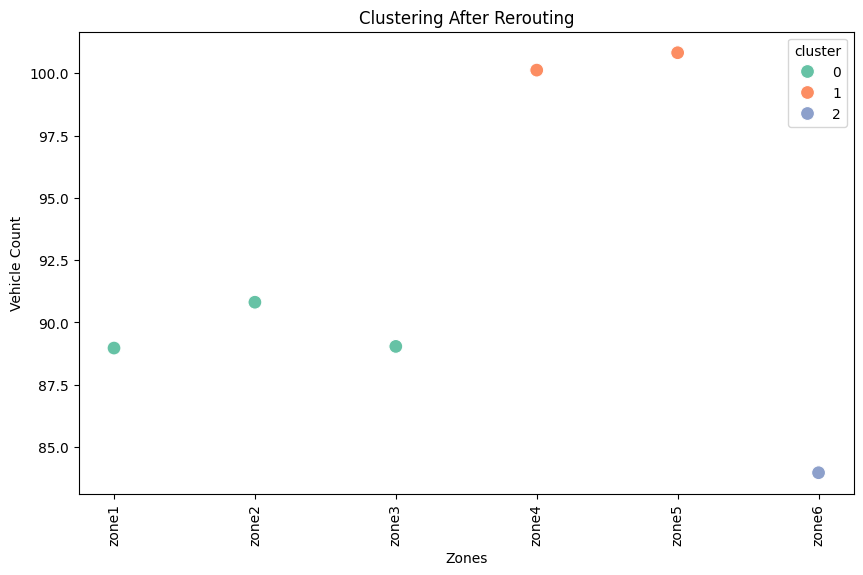

In [36]:
#Plot clustering results after rerouting
plt.figure(figsize=(10, 6))
sns.scatterplot(x=after_rerouting_data['rerouted_zone'],
                y=after_rerouting_data['vehicle_count'],
                hue=after_rerouting_data['cluster'],
                palette='Set2', s=100)
plt.xlabel("Zones")
plt.ylabel("Vehicle Count")
plt.title("Clustering After Rerouting")
plt.xticks(rotation=90)
plt.show()


In [37]:
#Group data by zone before rerouting and rerouted zones after rerouting
before_rerouting_data = df.groupby('zone')['vehicle_count'].mean().reset_index()
after_rerouting_data = df.groupby('rerouted_zone')['vehicle_count'].mean().reset_index()

In [38]:
#Merge before and after rerouting data for comparison
comparison_data = before_rerouting_data.merge(after_rerouting_data, left_on='zone', right_on='rerouted_zone', suffixes=('_before', '_after'))


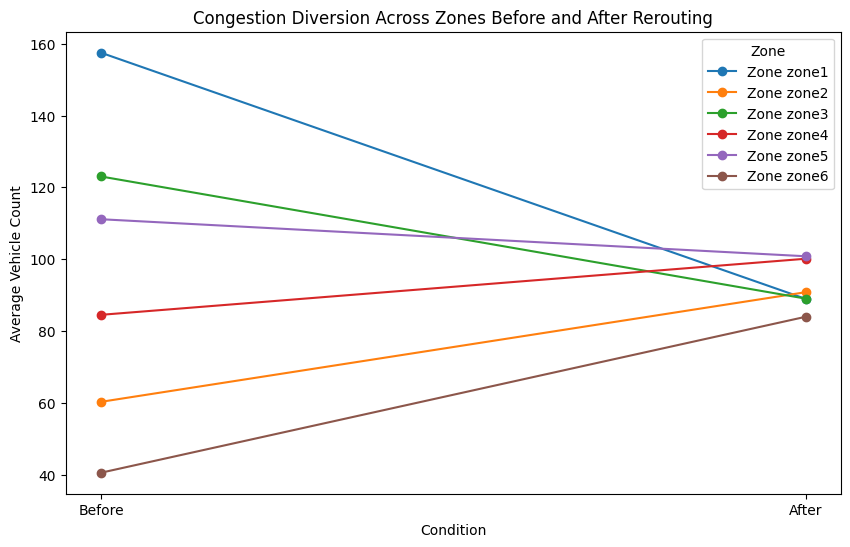

In [39]:

#Plot congestion diversion across zones before and after rerouting
plt.figure(figsize=(10, 6))
for zone in comparison_data['zone']:
    zone_data = comparison_data[comparison_data['zone'] == zone]
    plt.plot(['Before', 'After'],
             [zone_data['vehicle_count_before'].values[0], zone_data['vehicle_count_after'].values[0]],
             marker='o', label=f'Zone {zone}')
plt.title("Congestion Diversion Across Zones Before and After Rerouting")
plt.xlabel("Condition")
plt.ylabel("Average Vehicle Count")
plt.legend(title='Zone')

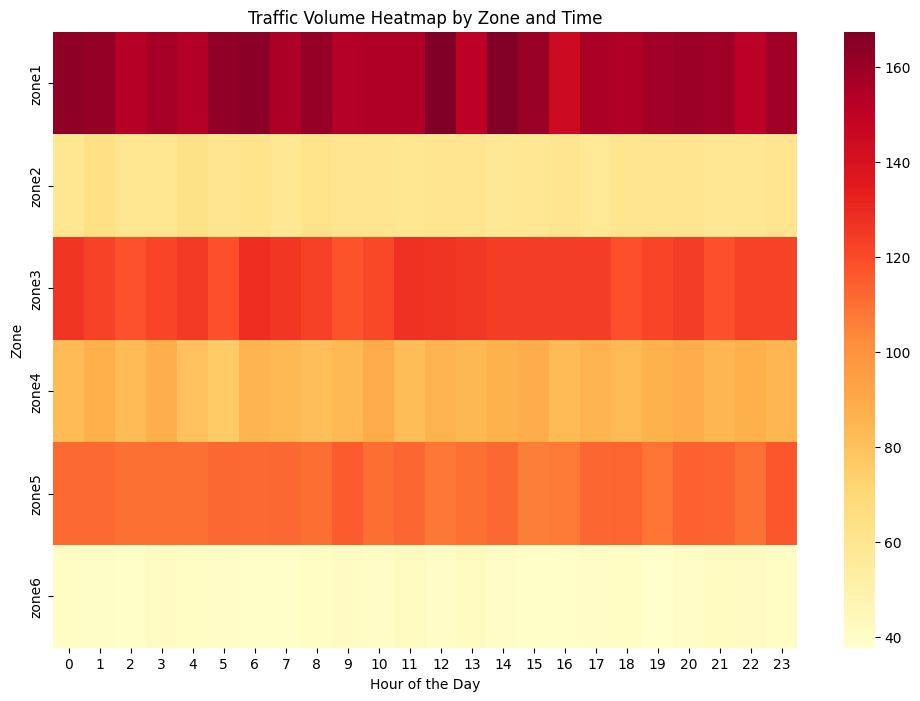

In [40]:
#Visualize traffic intensity across different zones and times of day
plt.figure(figsize=(12, 8))
traffic_pivot = df.pivot_table(values='vehicle_count', index='zone', columns=df.index.hour, aggfunc='mean')
sns.heatmap(traffic_pivot, cmap='YlOrRd')
plt.xlabel('Hour of the Day')
plt.ylabel('Zone')
plt.title('Traffic Volume Heatmap by Zone and Time')
plt.show()


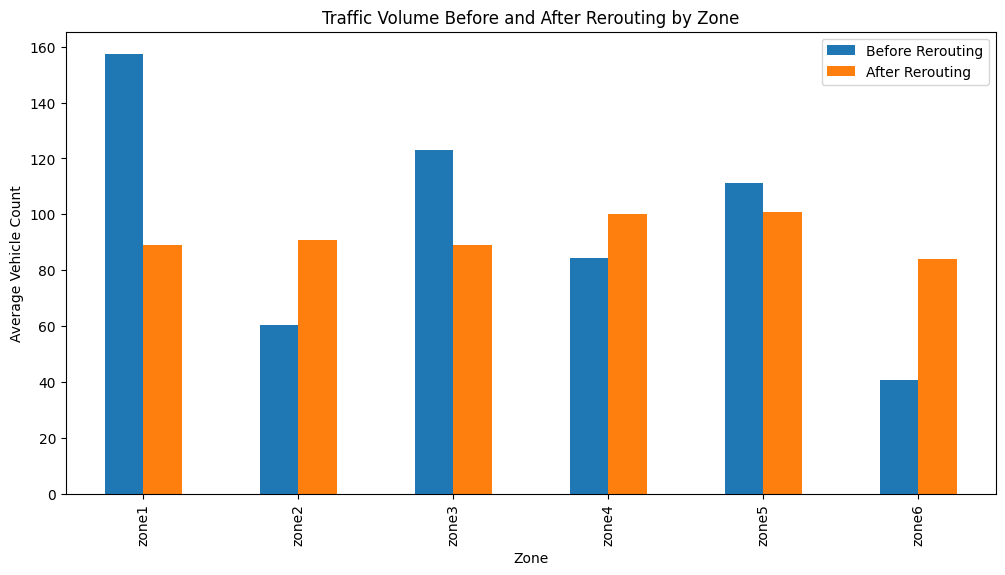

In [42]:
#Plot a clustered bar chart of traffic volume before and after rerouting by zone
comparison_data.set_index('zone', inplace=True)
comparison_data[['vehicle_count_before', 'vehicle_count_after']].plot(kind='bar', figsize=(12, 6))
plt.xlabel('Zone')
plt.ylabel('Average Vehicle Count')
plt.title('Traffic Volume Before and After Rerouting by Zone')
plt.legend(['Before Rerouting', 'After Rerouting'])
plt.show()


In [45]:
# Function to generate a traffic report from data
def generate_traffic_report(timestamp, congestion_level, zone, rerouted_zone, max_capacity, vehicle_count_before, vehicle_count_after):
    report = f"""
    Traffic Report:
    At {timestamp}, the congestion level in {zone} is {congestion_level*100:.1f}%. 
    Rerouting is suggested to {rerouted_zone}. The maximum road capacity is {max_capacity} vehicles. 
    Before rerouting, there were {vehicle_count_before} vehicles, and after rerouting, there are {vehicle_count_after} vehicles.
    """
    return report

# Load the CSV file containing predictions and data
# Loop through the data to generate reports
for index, row in predictions_df.head(10).iterrows(): 
    timestamp = row['timestamp']
    congestion_level = row['congestion_level']
    zone = row['zone']
    rerouted_zone = row['rerouted_zone']
    max_capacity = row['max_capacity']
    vehicle_count_before = row['vehicle_count_before']
    vehicle_count_after = row['vehicle_count_after']

    # Generate the traffic report using the data from the CSV
    traffic_report = generate_traffic_report(timestamp, congestion_level, zone, rerouted_zone, max_capacity, vehicle_count_before, vehicle_count_after)
    print(f"Traffic Report for {timestamp}:\n{traffic_report}\n")

    # Optional: Add a delay between reports to simulate processing time
time.sleep(1)

Traffic Report for 2024-01-01 00:00:00:

    Traffic Report:
    At 2024-01-01 00:00:00, the congestion level in zone1 is 100.0%. 
    Rerouting is suggested to zone5. The maximum road capacity is 22.63044814 vehicles. 
    Before rerouting, there were 280.0 vehicles, and after rerouting, there are 22.63044814 vehicles.
    

Traffic Report for 2024-01-01 00:00:00:

    Traffic Report:
    At 2024-01-01 00:00:00, the congestion level in zone2 is 100.0%. 
    Rerouting is suggested to zone1. The maximum road capacity is 24.123723 vehicles. 
    Before rerouting, there were 32.78379121 vehicles, and after rerouting, there are 24.123723 vehicles.
    

Traffic Report for 2024-01-01 00:00:00:

    Traffic Report:
    At 2024-01-01 00:00:00, the congestion level in zone3 is 100.0%. 
    Rerouting is suggested to zone5. The maximum road capacity is 10.001613124 vehicles. 
    Before rerouting, there were 142.5535391 vehicles, and after rerouting, there are 10.001613124 vehicles.
    

Traffi